In [4]:
from pyspark import SparkContext,SparkConf
from operator import add,itemgetter
from pyspark.sql import SparkSession,Row
from pandas import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer,Bucketizer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
import time
import math
class aslModel(object):
    def __init__(self,df,model=None):
        self.df = df
        self.model = model
        
    def train(self,df):
        trainDf,testDf = self.df.randomSplit([8.0,2.0],seed=40)
        userIndexer = StringIndexer(inputCol="user",outputCol="userid",handleInvalid="skip").fit(self.df)
        itemIndexer = StringIndexer(inputCol="item",outputCol="itemid",handleInvalid="skip").fit(self.df)
        als = ALS(rank=5,userCol="userid",
                       itemCol="itemid",ratingCol="rating",maxIter=5,regParam=0.0001)
        pipeAls = Pipeline(stages=[userIndexer,itemIndexer,als])
        evaluator = (RegressionEvaluator()
              .setMetricName("rmse")
              .setLabelCol("rating")
              .setPredictionCol("prediction"))
        paramGrid = (ParamGridBuilder() 
            .addGrid(als.maxIter,[5]) 
            .addGrid(als.regParam,logspace(0,4,5,base=3)*0.0001)
            .build())
        crossval = (CrossValidator(estimator=pipeAls,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2))  # use 3+ folds in practice
        cvModel = crossval.fit(trainDf)
        cvModel.transform(testDf).show()
        self.model = cvModel
    
    def train2(self,df,rank=5,maxIter=5,regParam=0.001):
        userIndexer = StringIndexer(inputCol="user",outputCol="userid",handleInvalid="error").fit(self.df)
        itemIndexer = StringIndexer(inputCol="item",outputCol="itemid").fit(self.df)
        alsModel = ALS(rank=rank,userCol="userid",itemCol="itemid",ratingCol="rating",maxIter=maxIter,regParam=regParam)
        pipeAls = Pipeline(stages=[userIndexer,itemIndexer,alsModel])
        pipeAlsModel = pipeAls.fit(df)
        predictionAls = pipeAlsModel.transform(df)
        predictionRecommendation= pipeAlsModel.transform(df)
        evaluator = RegressionEvaluator()\
              .setMetricName("rmse")\
              .setLabelCol("rating")\
              .setPredictionCol("prediction")
        print 'rmse:',evaluator.evaluate(df)
        self.model = pipeAlsModel
    
def recommend(test,model=None,topN=10):
    pre = model.transform(test)
    pre.registerTempTable('predictions')
    sqlString = "select user,item,prediction from \
        (select *,row_number() OVER(PARTITION BY predictions.user ORDER BY prediction desc) as flag\
        from predictions) t1 where t1.flag<=10"
    pre = spark.sql(sqlString)
    pre = pre.select(pre.user,pre.item,pre.prediction.alias('rating'))
    return pre
        
from Evaluator import Evaluator
def evaluate(evaluator):
    precise = evaluator.precision()
    coverage = evaluator.coverage()
    popularity = evaluator.popularity()
    recall = evaluator.recall()
    return precise,recall,coverage,popularity

if __name__ == "__main__": 
    import os
    PYSPARK_PYTHON = "/usr/bin/python2.7"
    os.environ["PYSPARK_PYTHON"] = PYSPARK_PYTHON
    conf = SparkConf().setAppName("alsCF").setMaster("yarn")
    conf.set('spark.yarn.dist.files',
            'file:/root/hadoop-2.6/spark/python/lib/pyspark.zip,file:/root/hadoop-2.6/spark/python/lib/py4j-0.10.4-src.zip')
    conf.set('spark.executor.cores','30')
    conf.set('spark.executor.memory','90g')
    conf.set('spark.executor.instances','3')
    conf.set('spark.sql.shuffle.partitions','400')
    conf.set('spark.default.parallelism','200')
    conf.set('spark.driver.maxResultSize', '10g')
    conf.set('spark.scheduler.mode','fair')
    conf.set("spark.yarn.scheduler.heartbeat.interval","7200000ms")
    conf.set("spark.executor.heartbeatInterval","7200000ms")
    conf.set("spark.network.timeout", "7200000ms")
    conf.set("spark.memory.storageFraction","0.25")
#     conf.set("spark.shuffle.file.buffer","128k").set("spark.reducer.maxSizeInFlight","96M")
    spark = SparkSession.builder\
        .config(conf=conf) \
        .getOrCreate()
    sc=spark.sparkContext 
    sc.setLogLevel('WARN')
    sc.setLocalProperty("spark.scheduler.pool", "als")
    start = time.time()
    inputPath = 'data/ml-1m/ratings.dat'
    inputPath = 'data/ml-100k/u.data'
    schema = StructType([
            StructField("user", StringType(), True),
            StructField("item", StringType(), True),
            StructField("rating", DoubleType(), True),
            StructField("timestamp", LongType(), True)])
#     ratingRdd = sc.textFile(inputPath).map(lambda line:line.split("\t"))\
#                     .map(lambda x:(x[0],x[1],float(x[2]),long(x[3])))
#     ratingDf = spark.createDataFrame(data=ratingRdd,schema=schema)
    inputPath = "data/amazon/rating_parquet"
    ratingDf = spark.read.parquet(inputPath)
    ratingDf = ratingDf.repartition(300)
    ratingDf.printSchema()
    ratingDf.show(5)
    n = ratingDf.count()
#     ratingDf = ratingDf.withColumn('score',col('rating')*0+1).select('user','item','score')    
    print 'total lines: %s' %n
    train,test = ratingDf.randomSplit([4.0,1.0],seed=40)
    train.cache()
    test.cache()
    userIndexer = StringIndexer(inputCol="user",outputCol="userid",handleInvalid="error").fit(ratingDf)
    itemIndexer = StringIndexer(inputCol="item",outputCol="itemid").fit(ratingDf)
    alsModel = ALS(rank=5,userCol="userid",itemCol="itemid",ratingCol="rating",maxIter=5,regParam=0.001)
    pipeAls = Pipeline(stages=[userIndexer,itemIndexer,alsModel])
    pipeAlsModel = pipeAls.fit(train)
    predictionAls = pipeAlsModel.transform(train)
    users = train.select('user').distinct()
    items = train.select('item').distinct()
    pre= pipeAlsModel.transform(users.crossJoin(items))
    from pyspark.sql import Window
    pre2 = pre.join(train,[train.item==pre.item,train.user==pre.user],'left_anti')
    window = Window.partitionBy('user').orderBy(desc('prediction'))
    pre2 = pre2.select('user','item',col('prediction').alias('rating'),rank().over(window).alias('rank')).filter('rank<=10')
    evaluator = Evaluator(train,test,pre2)
    (precise,recall,coverage,popularity) = evaluate(evaluator)
    print ('precise:%2.2f%%,  recall:%2.2f%%,  coverage:%2.2f%%,  popularity:%2.2f, time: %s s'
            %(precise*100,recall*100,coverage*100,popularity,end-start))
    start = time.time()
    pre= pipeAlsModel.transform(test)
    evaluator = RegressionEvaluator()\
          .setMetricName("rmse")\
          .setLabelCol("rating")\
          .setPredictionCol("prediction")
    print 'rmse:',evaluator.evaluate(pre.select('userid','itemid','rating','prediction').na.drop())
    end = time.time()
    print 'time:%s s' %(end-start)
    als = alsModel(ratingDf)
    als.train2(ratingDf)
# #     for NN in [5,10,20,40,60,80,100,120]:
#     for NN in [100]:
#         recTopN = recommend(test,als.model,topN=10,Normalization=False)
#         evaluator = Evaluator(train,test,pre)
#         (precise,recall,coverage,popularity) = evaluate(evaluator)
#         end = time.time()
#         print ('NN:%3d,  precise:%2.2f%%,  recall:%2.2f%%,  coverage:%2.2f%%,  popularity:%2.2f, time: %s s'
#                 %(NN,precise*100,recall*100,coverage*100,popularity,end-start))
#         start = time.time()

root
 |-- user: string (nullable = true)
 |-- item: string (nullable = true)
 |-- rating: double (nullable = true)

+--------------+----------+------+
|          user|      item|rating|
+--------------+----------+------+
|A1D0TFYHA8LMIE|B00004T11H|   5.0|
|A1D1QOPQPLOAW6|B000WJKE1Y|   5.0|
|A1D2CKTZND7NHO|B00BIQUXEI|   5.0|
|A1D38AIQNOIBX0|B00871CJFI|   1.0|
|A1D44YT0P8Q8XL|B00006JOAI|   5.0|
+--------------+----------+------+
only showing top 5 rows

total lines: 142831980


In [12]:
pre2 = y.join(train,[train.item==y.item,train.user==y.user],'left_anti')
window = Window.partitionBy('user').orderBy(desc('prediction'))
pre2 = pre2.select('user','item',col('prediction').alias('rating'),rank().over(window).alias('rank')).filter('rank<=10')
evaluator = Evaluator(train,test,pre2)
(precise,recall,coverage,popularity) = evaluate(evaluator)
print ('precise:%2.2f%%,  recall:%2.2f%%,  coverage:%2.2f%%,  popularity:%2.2f, time: %s s'
        %(precise*100,recall*100,coverage*100,popularity,end-start))

precise:0.04%,  recall:0.04%,  coverage:7.15%,  popularity:1.83, time: 53.3240408897 s


In [16]:
pre2 = y.join(train,[train.item==y.item,train.user==y.user],'left_anti')
window = Window.partitionBy('user').orderBy(desc('prediction'))
pre2 = pre2.select('user','item',col('prediction').alias('rating'),rank().over(window).alias('rank')).filter('rank<=10')
evaluator = Evaluator(train,test,pre2)
(precise,recall,coverage,popularity) = evaluate(evaluator)
print ('precise:%2.2f%%,  recall:%2.2f%%,  coverage:%2.2f%%,  popularity:%2.2f, time: %s s'
        %(precise*100,recall*100,coverage*100,popularity,end-start))

precise:9.06%,  recall:8.65%,  coverage:14.96%,  popularity:4.69, time: 53.3240408897 s


In [18]:
x=pre.join(ratingDf.groupBy('item').agg(count('*').alias('item_count')).withColumn('Pop',log2(col('item_count')+1)),on='item')
for alaph in xrange(6,10):
    y = x.select('user','item',(col('prediction')+alaph*col('Pop')).alias(('prediction')))
    pre2 = y.join(train,[train.item==y.item,train.user==y.user],'left_anti')
    window = Window.partitionBy('user').orderBy(desc('prediction'))
    pre2 = pre2.select('user','item',col('prediction').alias('rating'),rank().over(window).alias('rank')).filter('rank<=10')
    evaluator = Evaluator(train,test,pre2)
    (precise,recall,coverage,popularity) = evaluate(evaluator)
    print ('alahp:%s, precise:%2.2f%%,  recall:%2.2f%%,  coverage:%2.2f%%,  popularity:%2.2f, time: %s s'
            %(alaph,precise*100,recall*100,coverage*100,popularity,end-start))

alahp:1, precise:8.13%,  recall:7.76%,  coverage:11.78%,  popularity:3.95, time: 53.3240408897 s
alahp:2, precise:11.03%,  recall:10.53%,  coverage:10.64%,  popularity:5.26, time: 53.3240408897 s
alahp:3, precise:11.65%,  recall:11.13%,  coverage:9.19%,  popularity:5.67, time: 53.3240408897 s
alahp:4, precise:11.88%,  recall:11.34%,  coverage:7.93%,  popularity:5.81, time: 53.3240408897 s
alahp:5, precise:11.94%,  recall:11.40%,  coverage:6.37%,  popularity:5.88, time: 53.3240408897 s


In [20]:
x=pre.join(ratingDf.groupBy('item').agg(count('*').alias('item_count')).withColumn('Pop',log2(col('item_count')+1)),on='item')
for alaph in xrange(6,10):
    y = x.select('user','item',(0*col('prediction')+alaph*col('Pop')).alias(('prediction')))
    pre2 = y.join(train,[train.item==y.item,train.user==y.user],'left_anti')
    window = Window.partitionBy('user').orderBy(desc('prediction'))
    pre2 = pre2.select('user','item',col('prediction').alias('rating'),rank().over(window).alias('rank')).filter('rank<=10')
    evaluator = Evaluator(train,test,pre2)
    (precise,recall,coverage,popularity) = evaluate(evaluator)
    print ('alahp:%s, precise:%2.2f%%,  recall:%2.2f%%,  coverage:%2.2f%%,  popularity:%2.2f, time: %s s'
            %(alaph,precise*100,recall*100,coverage*100,popularity,end-start))

alahp:6, precise:11.54%,  recall:11.08%,  coverage:4.21%,  popularity:5.95, time: 53.3240408897 s
alahp:7, precise:11.54%,  recall:11.08%,  coverage:4.21%,  popularity:5.95, time: 53.3240408897 s


KeyboardInterrupt: 

+-------+------------------+-----------------+
|summary|        user_count|       item_count|
+-------+------------------+-----------------+
|  count|          21185128|         12650775|
|   mean| 6.742087184934639| 11.2903739098988|
| stddev|26.665782760139393|92.66059878026209|
|    min|                 1|                1|
|    max|             47018|            37600|
+-------+------------------+-----------------+

稀疏度：0.000053%


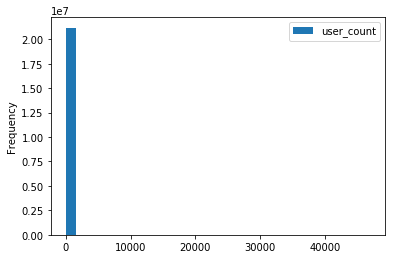

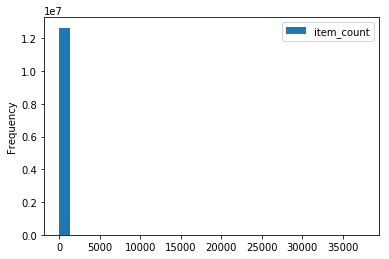

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
n = ratingDf.count()
ui_count  = ratingDf.agg(count('*').alias('ui'))
user_count = ratingDf.groupBy('user').agg(count('*').alias('user_count'))
item_count = ratingDf.groupBy('item').agg(count('*').alias('item_count'))
count_union = user_count.describe('user_count')\
          .join(item_count.describe('item_count'),on='summary',how='inner')
count_union.show()
print '稀疏度：%f%%' % (n/(21185128*12650775*1.0)*100)
user_count.toPandas().plot.hist(bins=30)
item_count.toPandas().plot.hist(bins=30)

In [7]:
sc.stop()
spark.stop()